## this notebook will be to create cross sections at the gates to do trends

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [ ]:
from matplotlib.colors import BoundaryNorm


In [2]:
# I think we should create a python script to load value and from filename for a 3D or a 2D field
# function should take years, mask, filename, terms I want to load, also the directory

# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2006,2018,1)  # start from the beginning of the regime shift

In [8]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1

In [9]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz),
                                                                (x_nzru, y_nzru, choose_UV_nzru)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

## load the ADV_th, theta, salt, Uvel for the gate

Compare to Wang 2019: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083837

In [10]:
tstart =0

In [12]:
# To load later
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_fourgates.npy", allow_pickle=True).item()

# Access the saved dictionaries
heat_transport_timeseries = loaded_data["heat_transport_timeseries"]
theta_timeseries = loaded_data["theta_timeseries"]
salt_timeseries = loaded_data["salt_timeseries"]
vel_timeseries = loaded_data["vel_timeseries"]

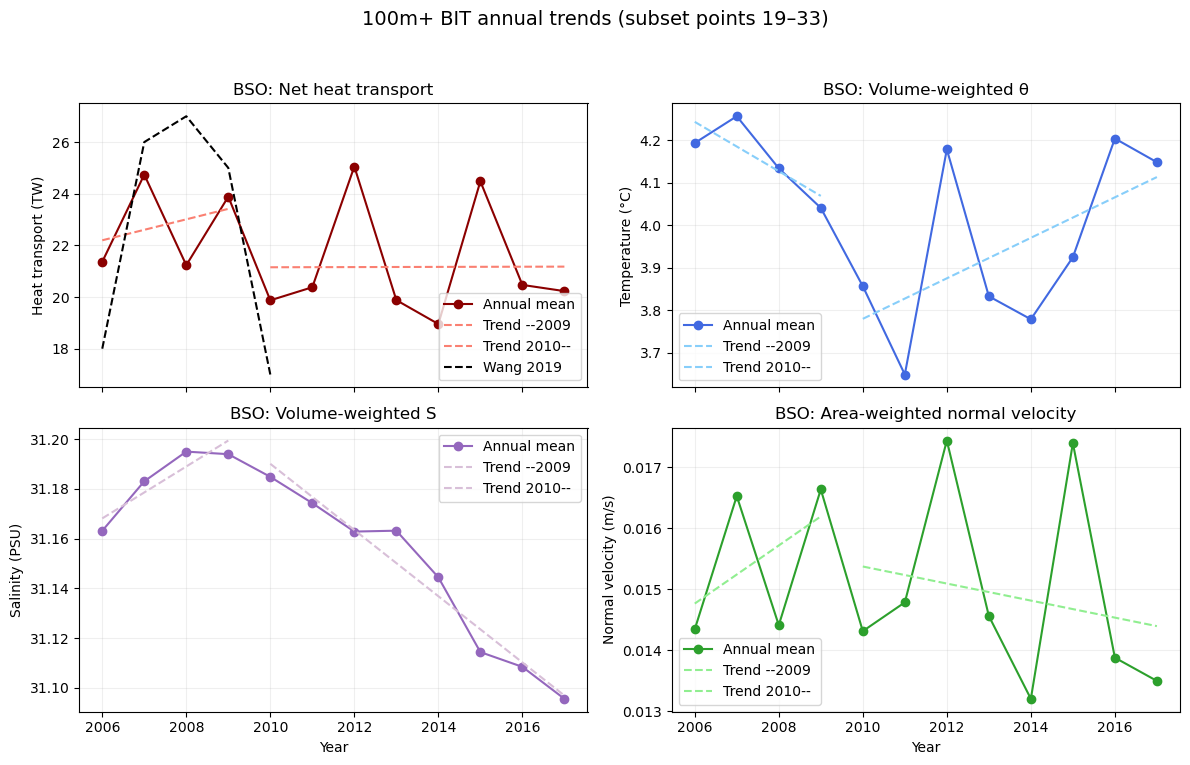

In [37]:
dterm = 8      # the depth to split at (100m)
splity = 4      # the year to split the trend lines and do both


# ------------ Config ------------
gate = "BSO"
# Use a subset along the gate if you want (same as your earlier slice); else set to slice(None)
gate_slice = slice(19, 34)

# Pull indices for this gate (C-grid)
y_idx, x_idx = gate_indices[gate]
y_idx = y_idx[gate_slice]
x_idx = x_idx[gate_slice]
npts  = len(x_idx)

# Shapes
nyears = heat_transport_timeseries[gate].shape[0]
months = 12
years_arr = np.asarray(allyears[:nyears], dtype=int)

# ------------ Helpers ------------
def annual_mean(series_monthly):
    """(nyears,12) -> (nyears,) ignoring NaNs."""
    return np.nanmean(series_monthly, axis=1)

def fit_trend(x_years, y):
    """Return fitted y-hat for a linear trend over years."""
    m, b = np.polyfit(x_years[np.isfinite(y)], y[np.isfinite(y)], 1)
    return m * x_years + b

# ------------ Heat transport (net, TW) ------------
# heat_transport_timeseries[gate]: (nyears,12,nz,npts), already W, signed "into basin = +"
Q_W = heat_transport_timeseries[gate][:, :, dterm:, gate_slice]               # (nyears,12,nz,npts)
Q_monthly_TW = np.nansum(Q_W, axis=(2, 3)) / 1e12                        # (nyears,12) TW
Q_annual_TW  = annual_mean(Q_monthly_TW)                                  # (nyears,)

# ------------ Volume-weighted θ and S ------------
# theta_timeseries[gate], salt_timeseries[gate] are θ×volume and S×volume on (nyears,12,nz,npts)
theta_vol = theta_timeseries[gate][:, :, dterm:, gate_slice]                   # °C·m^3
salt_vol  =  salt_timeseries[gate][:, :, dterm:, gate_slice]                   # PSU·m^3

# Build layer volumes for these gate points (constant in time)
DRF1d      = np.asarray(mygrid["DRF"]).reshape(-1)                        # (nz,)
hFacC_line = mygrid["hFacC"][:, y_idx, x_idx]                             # (nz,npts)
RAC_line   = mygrid["RAC"][y_idx, x_idx]                                  # (npts,)
vol_layer  = DRF1d[:, None] * hFacC_line * RAC_line[None, :]              # (nz,npts)

# Broadcast to time dims
VOL4D = vol_layer[None, None, dterm:, :]                                       # (1,1,nz,npts)

# Monthly volume-weighted means
theta_monthly = np.nansum(theta_vol, axis=(2, 3)) / np.nansum(VOL4D, axis=(2, 3))  # (nyears,12) °C
salt_monthly  = np.nansum(salt_vol,  axis=(2, 3)) / np.nansum(VOL4D, axis=(2, 3))  # (nyears,12) PSU

theta_annual = annual_mean(theta_monthly)                                  # (nyears,)
salt_annual  = annual_mean(salt_monthly)                                   # (nyears,)

# ------------ Area-weighted normal velocity ------------
# vel_timeseries[gate]: (nyears,12,nz,npts) normal velocity (m/s) at the same gate cells
vel_gate = vel_timeseries[gate][:, :, dterm:, gate_slice]                       # (nyears,12,nz,npts)

# Face areas for U/V (aligned on C-size arrays)
A_U = (mygrid["DYG"][y_idx, x_idx][None, :] * DRF1d[:, None] * mygrid["hFacW"][:, y_idx, x_idx])
A_V = (mygrid["DXG"][y_idx, x_idx][None, :] * DRF1d[:, None] * mygrid["hFacS"][:, y_idx, x_idx])

# Choose which face to use at each (z,point). Make sure choose_UV[gate] is on C-grid; broadcast if 2D.
UVsel = choose_UV[gate]
UVsel = UVsel if UVsel.ndim == 3 else np.broadcast_to(UVsel, (len(DRF1d),) + UVsel.shape)
UVsel_line = UVsel[:, y_idx, x_idx]                                        # (nz,npts)
A_face = np.where(UVsel_line == 'H', A_U, A_V)                              # (nz,npts)

A4D = A_face[None, None, dterm:, :]                                              # (1,1,nz,npts)
vel_monthly = np.nansum(vel_gate * A4D, axis=(2, 3)) / np.nansum(A4D, axis=(2, 3))  # (nyears,12) m/s
vel_annual  = annual_mean(vel_monthly)

# ------------ Trends ------------
Q_trend     = fit_trend(years_arr[:splity], Q_annual_TW[:splity])
theta_trend = fit_trend(years_arr[:splity], theta_annual[:splity])
salt_trend  = fit_trend(years_arr[:splity],  salt_annual[:splity])
vel_trend   = fit_trend(years_arr[:splity],   vel_annual[:splity])

# another set of trends for the split at 2010
Q_trend2     = fit_trend(years_arr[splity:], Q_annual_TW[splity:])
theta_trend2 = fit_trend(years_arr[splity:], theta_annual[splity:])
salt_trend2  = fit_trend(years_arr[splity:],  salt_annual[splity:])
vel_trend2   = fit_trend(years_arr[splity:],   vel_annual[splity:])

# ------------ Plot 2x2 ------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
l1 = "Trend --" + str(years_arr[splity-1])
l2 = "Trend " + str(years_arr[splity]) + "--"

# (1) Heat transport
ax = axes[0, 0]
ax.plot(years_arr, Q_annual_TW, 'o-', color='darkred', label='Annual mean')
ax.plot(years_arr[:splity], Q_trend,      '--', color='salmon',  label=l1)
ax.plot(years_arr[splity:], Q_trend2,      '--', color='salmon',  label=l2)

# also plot the trend from Wang 2019
wang2 = np.array([18,26,27,25,17])
ax.plot(years_arr[:splity+1],wang2, '--', color = "black",label="Wang 2019")

ax.set_ylabel('Heat transport (TW)')
ax.set_title(f'{gate}: Net heat transport')
ax.grid(alpha=0.2); ax.legend()

# (2) Temperature
ax = axes[0, 1]
ax.plot(years_arr, theta_annual, 'o-', color='royalblue', label='Annual mean')
ax.plot(years_arr[:splity], theta_trend,  '--', color='lightskyblue', label=l1)
ax.plot(years_arr[splity:], theta_trend2,  '--', color='lightskyblue', label=l2)
ax.set_ylabel('Temperature (°C)')
ax.set_title(f'{gate}: Volume-weighted θ')
ax.grid(alpha=0.2); ax.legend()

# (3) Salinity
ax = axes[1, 0]
ax.plot(years_arr, salt_annual, 'o-', color='tab:purple', label='Annual mean')
ax.plot(years_arr[:splity], salt_trend,  '--', color='thistle',    label=l1)
ax.plot(years_arr[splity:], salt_trend2,  '--', color='thistle',    label=l2)
ax.set_ylabel('Salinity (PSU)')
ax.set_title(f'{gate}: Volume-weighted S')
ax.grid(alpha=0.2); ax.legend()

# (4) Velocity
ax = axes[1, 1]
ax.plot(years_arr, vel_annual, 'o-', color='tab:green', label='Annual mean')
ax.plot(years_arr[:splity], vel_trend,  '--', color='lightgreen', label=l1)
ax.plot(years_arr[splity:], vel_trend2,  '--', color='lightgreen', label=l2)
ax.set_ylabel('Normal velocity (m/s)')
ax.set_title(f'{gate}: Area-weighted normal velocity')
ax.grid(alpha=0.2); ax.legend()

for ax in axes[-1, :]:
    ax.set_xlabel('Year')

fig.suptitle(f'100m+ BIT annual trends (subset points {gate_slice.start}–{gate_slice.stop-1})', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


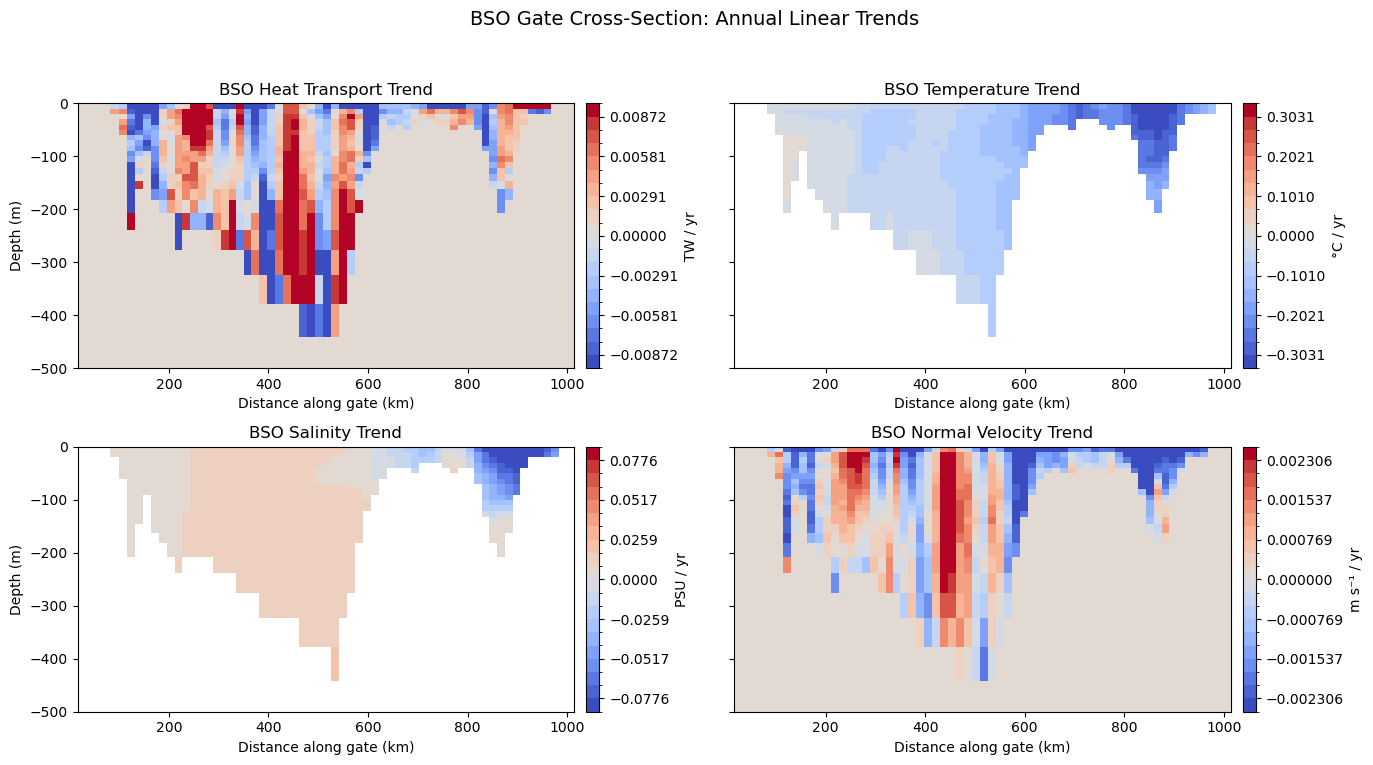

In [39]:
sty = 0
splity = 4

# -------- config --------
gate = "BSO"
gate_slice = slice(0, None)    # subset along-gate points if desired
depth_max = 500                # m (plotting limit)

# -------- indices & distances --------
y_idx_full, x_idx_full = gate_indices[gate]
y_idx = y_idx_full[gate_slice]
x_idx = x_idx_full[gate_slice]
X = gate_distances[gate][gate_slice]           # (npts,)

nyears = heat_transport_timeseries[gate].shape[0]
years_arr = np.asarray(allyears[:nyears], dtype=float)[sty:splity]
nz = mygrid['DRF'].size
npts = len(X)

# depth edges (negative down) for pcolormesh
DRF = np.asarray(mygrid['DRF']).reshape(-1)
Y_edges = np.concatenate([[0.0], -np.cumsum(DRF)])         # (nz+1,)
# x edges
dx_last = (X[-1]-X[-2]) if (len(X) > 1) else 1.0
X_edges = np.concatenate([X, [X[-1] + dx_last]])            # (npts+1,)

# -------- helper: annual mean then linear trend slope --------
def annual_mean(arr_y_m):  # (nyears, 12, nz, npts) -> (nyears, nz, npts)
    return np.nanmean(arr_y_m, axis=1)

def slope_per_pixel(Y_yr, years):
    """Y_yr: (nyears, nz, npts) -> slopes (nz, npts) using np.polyfit at each pixel."""
    out = np.full(Y_yr.shape[1:], np.nan, dtype=float)
    for k in range(Y_yr.shape[1]):         # depth
        for j in range(Y_yr.shape[2]):     # gate point
            y = Y_yr[:, k, j]
            ok = np.isfinite(y)
            if ok.sum() >= 2:
                out[k, j] = np.polyfit(years[ok], y[ok], 1)[0]
    return out

# -------- volume (for θ & S weighting) & face area (if needed) --------
hFacC_line = mygrid['hFacC'][:, y_idx, x_idx]               # (nz, npts)
RAC_line   = mygrid['RAC'][y_idx, x_idx]                    # (npts,)
VOL_layer  = DRF[:, None] * hFacC_line * RAC_line[None, :]  # (nz, npts)

# -------- build yearly fields --------
# Heat transport (W) -> annual mean (nyears, nz, npts); trend => TW/yr
Q_W = annual_mean(heat_transport_timeseries[gate][sty:splity, :, :, gate_slice])         # (nyears,nz,npts)
Q_trend_TWyr = slope_per_pixel(Q_W, years_arr) / 1e12                           # TW/yr

# Temperature θ×Vol -> θ (°C) yearly then trend °C/yr
theta_vol = annual_mean(theta_timeseries[gate][sty:splity, :, :, gate_slice])            # (nyears,nz,npts) °C·m^3
# divide by volume (constant across time)
theta_yr = theta_vol / np.where(VOL_layer[None, :, :] > 0, VOL_layer[None, :, :], np.nan)
theta_trend = slope_per_pixel(theta_yr, years_arr)                               # °C/yr

# Salinity S×Vol -> S (PSU) yearly then trend PSU/yr
salt_vol = annual_mean(salt_timeseries[gate][sty:splity, :, :, gate_slice])              # PSU·m^3
salt_yr = salt_vol / np.where(VOL_layer[None, :, :] > 0, VOL_layer[None, :, :], np.nan)
salt_trend = slope_per_pixel(salt_yr, years_arr)                                 # PSU/yr

# Normal velocity (m/s) yearly then trend m/s/yr
vel_yr = annual_mean(vel_timeseries[gate][sty:splity, :, :, gate_slice])                 # (nyears,nz,npts)
vel_trend = slope_per_pixel(vel_yr, years_arr)                                   # m/s/yr

# -------- color scales (symmetric by robust percentiles) --------
def sym_levels(A, pct=98, n=21, scale=1.0):
    lo, hi = np.nanpercentile(A*scale, [100-pct, pct])
    m = max(abs(lo), abs(hi))
    return np.linspace(-m, m, n)

cmap = plt.get_cmap('coolwarm')
lev_Q = sym_levels(Q_trend_TWyr, pct=98, n=21)        # TW/yr
lev_T = sym_levels(theta_trend,   pct=98, n=21)       # °C/yr
lev_S = sym_levels(salt_trend,    pct=98, n=21)       # PSU/yr
lev_U = sym_levels(vel_trend,     pct=98, n=21)       # m/s/yr

norm_Q = BoundaryNorm(lev_Q, cmap.N)
norm_T = BoundaryNorm(lev_T, cmap.N)
norm_S = BoundaryNorm(lev_S, cmap.N)
norm_U = BoundaryNorm(lev_U, cmap.N)

# -------- plot 2×2 cross-section of trends --------
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# (1) Heat transport trend
ax = axes[0, 0]
im = ax.pcolormesh(X_edges, Y_edges, Q_trend_TWyr, cmap=cmap, norm=norm_Q, shading='auto')
ax.set_ylim(-depth_max, 0); ax.set_title(f"{gate} Heat Transport Trend")
ax.set_xlabel("Distance along gate (km)"); ax.set_ylabel("Depth (m)")
fig.colorbar(im, ax=ax, pad=0.02, label="TW / yr")

# (2) Temperature trend (volume-weighted)
ax = axes[0, 1]
im = ax.pcolormesh(X_edges, Y_edges, theta_trend, cmap=cmap, norm=norm_T, shading='auto')
ax.set_ylim(-depth_max, 0); ax.set_title(f"{gate} Temperature Trend")
ax.set_xlabel("Distance along gate (km)")
fig.colorbar(im, ax=ax, pad=0.02, label="°C / yr")

# (3) Salinity trend (volume-weighted)
ax = axes[1, 0]
im = ax.pcolormesh(X_edges, Y_edges, salt_trend, cmap=cmap, norm=norm_S, shading='auto')
ax.set_ylim(-depth_max, 0); ax.set_title(f"{gate} Salinity Trend")
ax.set_xlabel("Distance along gate (km)"); ax.set_ylabel("Depth (m)")
fig.colorbar(im, ax=ax, pad=0.02, label="PSU / yr")

# (4) Normal velocity trend
ax = axes[1, 1]
im = ax.pcolormesh(X_edges, Y_edges, vel_trend, cmap=cmap, norm=norm_U, shading='auto')
ax.set_ylim(-depth_max, 0); ax.set_title(f"{gate} Normal Velocity Trend")
ax.set_xlabel("Distance along gate (km)")
fig.colorbar(im, ax=ax, pad=0.02, label="m s⁻¹ / yr")

fig.suptitle(f"{gate} Gate Cross-Section: Annual Linear Trends", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(f"{gate}_gate_trends_2x2.png", dpi=300)
plt.show()


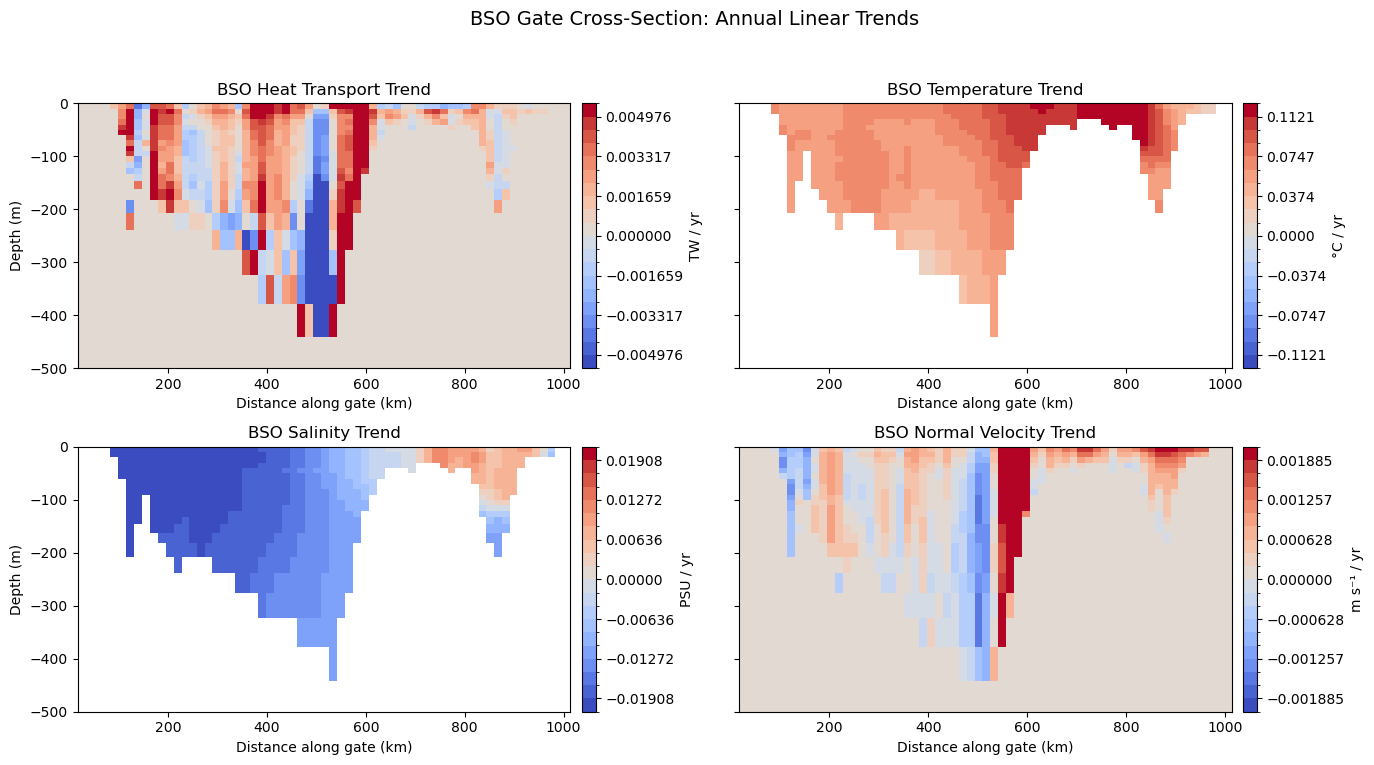

In [40]:
sty = 4
splity = 12

# -------- config --------
gate = "BSO"
gate_slice = slice(0, None)    # subset along-gate points if desired
depth_max = 500                # m (plotting limit)

# -------- indices & distances --------
y_idx_full, x_idx_full = gate_indices[gate]
y_idx = y_idx_full[gate_slice]
x_idx = x_idx_full[gate_slice]
X = gate_distances[gate][gate_slice]           # (npts,)

nyears = heat_transport_timeseries[gate].shape[0]
years_arr = np.asarray(allyears[:nyears], dtype=float)[sty:splity]
nz = mygrid['DRF'].size
npts = len(X)

# depth edges (negative down) for pcolormesh
DRF = np.asarray(mygrid['DRF']).reshape(-1)
Y_edges = np.concatenate([[0.0], -np.cumsum(DRF)])         # (nz+1,)
# x edges
dx_last = (X[-1]-X[-2]) if (len(X) > 1) else 1.0
X_edges = np.concatenate([X, [X[-1] + dx_last]])            # (npts+1,)

# -------- helper: annual mean then linear trend slope --------
def annual_mean(arr_y_m):  # (nyears, 12, nz, npts) -> (nyears, nz, npts)
    return np.nanmean(arr_y_m, axis=1)

def slope_per_pixel(Y_yr, years):
    """Y_yr: (nyears, nz, npts) -> slopes (nz, npts) using np.polyfit at each pixel."""
    out = np.full(Y_yr.shape[1:], np.nan, dtype=float)
    for k in range(Y_yr.shape[1]):         # depth
        for j in range(Y_yr.shape[2]):     # gate point
            y = Y_yr[:, k, j]
            ok = np.isfinite(y)
            if ok.sum() >= 2:
                out[k, j] = np.polyfit(years[ok], y[ok], 1)[0]
    return out

# -------- volume (for θ & S weighting) & face area (if needed) --------
hFacC_line = mygrid['hFacC'][:, y_idx, x_idx]               # (nz, npts)
RAC_line   = mygrid['RAC'][y_idx, x_idx]                    # (npts,)
VOL_layer  = DRF[:, None] * hFacC_line * RAC_line[None, :]  # (nz, npts)

# -------- build yearly fields --------
# Heat transport (W) -> annual mean (nyears, nz, npts); trend => TW/yr
Q_W = annual_mean(heat_transport_timeseries[gate][sty:splity, :, :, gate_slice])         # (nyears,nz,npts)
Q_trend_TWyr = slope_per_pixel(Q_W, years_arr) / 1e12                           # TW/yr

# Temperature θ×Vol -> θ (°C) yearly then trend °C/yr
theta_vol = annual_mean(theta_timeseries[gate][sty:splity, :, :, gate_slice])            # (nyears,nz,npts) °C·m^3
# divide by volume (constant across time)
theta_yr = theta_vol / np.where(VOL_layer[None, :, :] > 0, VOL_layer[None, :, :], np.nan)
theta_trend = slope_per_pixel(theta_yr, years_arr)                               # °C/yr

# Salinity S×Vol -> S (PSU) yearly then trend PSU/yr
salt_vol = annual_mean(salt_timeseries[gate][sty:splity, :, :, gate_slice])              # PSU·m^3
salt_yr = salt_vol / np.where(VOL_layer[None, :, :] > 0, VOL_layer[None, :, :], np.nan)
salt_trend = slope_per_pixel(salt_yr, years_arr)                                 # PSU/yr

# Normal velocity (m/s) yearly then trend m/s/yr
vel_yr = annual_mean(vel_timeseries[gate][sty:splity, :, :, gate_slice])                 # (nyears,nz,npts)
vel_trend = slope_per_pixel(vel_yr, years_arr)                                   # m/s/yr

# -------- color scales (symmetric by robust percentiles) --------
def sym_levels(A, pct=98, n=21, scale=1.0):
    lo, hi = np.nanpercentile(A*scale, [100-pct, pct])
    m = max(abs(lo), abs(hi))
    return np.linspace(-m, m, n)

cmap = plt.get_cmap('coolwarm')
lev_Q = sym_levels(Q_trend_TWyr, pct=98, n=21)        # TW/yr
lev_T = sym_levels(theta_trend,   pct=98, n=21)       # °C/yr
lev_S = sym_levels(salt_trend,    pct=98, n=21)       # PSU/yr
lev_U = sym_levels(vel_trend,     pct=98, n=21)       # m/s/yr

norm_Q = BoundaryNorm(lev_Q, cmap.N)
norm_T = BoundaryNorm(lev_T, cmap.N)
norm_S = BoundaryNorm(lev_S, cmap.N)
norm_U = BoundaryNorm(lev_U, cmap.N)

# -------- plot 2×2 cross-section of trends --------
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# (1) Heat transport trend
ax = axes[0, 0]
im = ax.pcolormesh(X_edges, Y_edges, Q_trend_TWyr, cmap=cmap, norm=norm_Q, shading='auto')
ax.set_ylim(-depth_max, 0); ax.set_title(f"{gate} Heat Transport Trend")
ax.set_xlabel("Distance along gate (km)"); ax.set_ylabel("Depth (m)")
fig.colorbar(im, ax=ax, pad=0.02, label="TW / yr")

# (2) Temperature trend (volume-weighted)
ax = axes[0, 1]
im = ax.pcolormesh(X_edges, Y_edges, theta_trend, cmap=cmap, norm=norm_T, shading='auto')
ax.set_ylim(-depth_max, 0); ax.set_title(f"{gate} Temperature Trend")
ax.set_xlabel("Distance along gate (km)")
fig.colorbar(im, ax=ax, pad=0.02, label="°C / yr")

# (3) Salinity trend (volume-weighted)
ax = axes[1, 0]
im = ax.pcolormesh(X_edges, Y_edges, salt_trend, cmap=cmap, norm=norm_S, shading='auto')
ax.set_ylim(-depth_max, 0); ax.set_title(f"{gate} Salinity Trend")
ax.set_xlabel("Distance along gate (km)"); ax.set_ylabel("Depth (m)")
fig.colorbar(im, ax=ax, pad=0.02, label="PSU / yr")

# (4) Normal velocity trend
ax = axes[1, 1]
im = ax.pcolormesh(X_edges, Y_edges, vel_trend, cmap=cmap, norm=norm_U, shading='auto')
ax.set_ylim(-depth_max, 0); ax.set_title(f"{gate} Normal Velocity Trend")
ax.set_xlabel("Distance along gate (km)")
fig.colorbar(im, ax=ax, pad=0.02, label="m s⁻¹ / yr")

fig.suptitle(f"{gate} Gate Cross-Section: Annual Linear Trends", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(f"{gate}_gate_trends_2x2.png", dpi=300)
plt.show()
